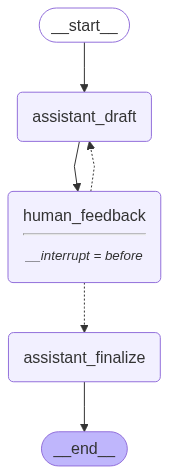

In [8]:
import os
from typing import Literal, Optional
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver
from pprint import pprint
from dotenv import load_dotenv
from langchain_openai import AzureChatOpenAI

load_dotenv()
# --- Model Definition ---
# OpenAI API key configured in .env file
model = AzureChatOpenAI(
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    openai_api_version="2024-12-01-preview",
)


# --- Graph State Definition ---
class DraftReviewState(MessagesState):
    human_request: str
    human_comment: Optional[str]
    status: Literal["approved", "feedback"]
    assistant_response: str


# --- Graph Nodes Definition ---
def assistant_draft(state: DraftReviewState) -> DraftReviewState:
    user_message = HumanMessage(content=state["human_request"])
    status = state.get("status", "approved")

    if (status == "feedback" and state.get("human_comment")):
        human_comment = HumanMessage(content=state["human_comment"])

        system_message = SystemMessage(content=(f"""
        You are an AI assistant revising your previous draft. Carefully review the human's 
        feedback and update your reply accordingly. Address all comments, corrections, 
        or suggestions provided by the human. Ensure your revised response fully 
        integrates the feedback, improves clarity, and resolves any issues raised.
        """))

        messages = [user_message] + state["messages"] + [system_message, human_comment]
        all_messages = state["messages"] + [human_comment]

    else:
        system_message = SystemMessage(content=("""
        You are an AI assistant. Your goal is to fully understand and fulfill the user's 
        request by preparing a relevant, clear, and helpful draft reply. Focus on addressing 
        the user's needs directly and comprehensively. 
        Do not reference any previous human feedback at this stage.
        """))
        messages = [system_message, user_message]
        all_messages = state["messages"]
    
    response = model.invoke(messages)

    all_messages = all_messages + [response]

    return {
        **state,
        "messages": all_messages,
        "assistant_response": response.content
    }


def human_feedback(state: DraftReviewState):
    pass


def assistant_finalize(state: DraftReviewState) -> DraftReviewState:
    system_message = """
    You are an AI assistant. The user has approved your draft. Carefully 
    review your reply and make any final improvements to clarity, tone, and 
    completeness. Ensure the response is polished, professional, and ready 
    to be delivered as the final answer.
    """
    messages = [system_message] + state["messages"]
    response = model.invoke(messages)

    all_messages = state['messages'] + [response]

    return {
        **state,
        "messages": all_messages,
        "assistant_response": response.content
    }
    

# --- Router Function ---
def feedback_router(state: DraftReviewState) -> str:
    if state['status'] == 'approved':
        return 'assistant_finalize'
    else:
        return 'assistant_draft'

# --- Graph Construction ---
builder = StateGraph(DraftReviewState)

# builder.add_node('start', start_node)
builder.add_node('assistant_draft', assistant_draft)
builder.add_node('human_feedback', human_feedback)
builder.add_node('assistant_finalize', assistant_finalize)

builder.add_edge(START, 'assistant_draft')
builder.add_edge('assistant_draft', 'human_feedback')
builder.add_conditional_edges('human_feedback', feedback_router, {'assistant_finalize': 'assistant_finalize', 'assistant_draft': 'assistant_draft'})
builder.add_edge('assistant_finalize', END)

memory = MemorySaver()
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
config = {"configurable": {"thread_id": "1"}}

result = graph.invoke({"human_request": "Explain what is HITL"}, config)
result

{'messages': [AIMessage(content='HITL stands for Human-In-The-Loop, a concept primarily used in fields such as artificial intelligence, machine learning, and automated systems. It refers to a model of operation where human input is incorporated into the decision-making process or task execution. HITL is essential in situations where complex, nuanced, or context-dependent decisions are necessary, and it enhances the overall output and reliability of automated systems.\n\nHere are some key aspects of HITL:\n\n1. **Collaboration**: HITL emphasizes the collaboration between humans and machines, where humans provide oversight, validation, and necessary adjustments to automated processes.\n\n2. **Quality Control**: Human intervention is often required to ensure the quality and accuracy of the output, especially in tasks involving subjective judgments, ethics, or sensitivity to context.\n\n3. **Learning and Improvement**: By including human feedback, systems can learn and improve over time, r

In [10]:
state = graph.get_state(config)
pprint(state)

StateSnapshot(values={'messages': [AIMessage(content='HITL stands for Human-In-The-Loop, a concept primarily used in fields such as artificial intelligence, machine learning, and automated systems. It refers to a model of operation where human input is incorporated into the decision-making process or task execution. HITL is essential in situations where complex, nuanced, or context-dependent decisions are necessary, and it enhances the overall output and reliability of automated systems.\n\nHere are some key aspects of HITL:\n\n1. **Collaboration**: HITL emphasizes the collaboration between humans and machines, where humans provide oversight, validation, and necessary adjustments to automated processes.\n\n2. **Quality Control**: Human intervention is often required to ensure the quality and accuracy of the output, especially in tasks involving subjective judgments, ethics, or sensitivity to context.\n\n3. **Learning and Improvement**: By including human feedback, systems can learn and

In [11]:
graph.update_state(config, {
    "status": "feedback",
    "human_comment": "Make your answer only one sentence short!"
})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0851da-ecdc-6fba-8002-8d1bf352dc01'}}

In [12]:
resumed_result = graph.invoke(None, config)
resumed_result

{'messages': [AIMessage(content='HITL stands for Human-In-The-Loop, a concept primarily used in fields such as artificial intelligence, machine learning, and automated systems. It refers to a model of operation where human input is incorporated into the decision-making process or task execution. HITL is essential in situations where complex, nuanced, or context-dependent decisions are necessary, and it enhances the overall output and reliability of automated systems.\n\nHere are some key aspects of HITL:\n\n1. **Collaboration**: HITL emphasizes the collaboration between humans and machines, where humans provide oversight, validation, and necessary adjustments to automated processes.\n\n2. **Quality Control**: Human intervention is often required to ensure the quality and accuracy of the output, especially in tasks involving subjective judgments, ethics, or sensitivity to context.\n\n3. **Learning and Improvement**: By including human feedback, systems can learn and improve over time, r

In [13]:
graph.update_state(config, {
    "status": "approved"
})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0851db-bdcb-627a-8005-346f01f2dd8c'}}

In [14]:
resumed_result = graph.invoke(None, config)
resumed_result

{'messages': [AIMessage(content='HITL stands for Human-In-The-Loop, a concept primarily used in fields such as artificial intelligence, machine learning, and automated systems. It refers to a model of operation where human input is incorporated into the decision-making process or task execution. HITL is essential in situations where complex, nuanced, or context-dependent decisions are necessary, and it enhances the overall output and reliability of automated systems.\n\nHere are some key aspects of HITL:\n\n1. **Collaboration**: HITL emphasizes the collaboration between humans and machines, where humans provide oversight, validation, and necessary adjustments to automated processes.\n\n2. **Quality Control**: Human intervention is often required to ensure the quality and accuracy of the output, especially in tasks involving subjective judgments, ethics, or sensitivity to context.\n\n3. **Learning and Improvement**: By including human feedback, systems can learn and improve over time, r

In [15]:
state = graph.get_state(config)
pprint(state)

StateSnapshot(values={'messages': [AIMessage(content='HITL stands for Human-In-The-Loop, a concept primarily used in fields such as artificial intelligence, machine learning, and automated systems. It refers to a model of operation where human input is incorporated into the decision-making process or task execution. HITL is essential in situations where complex, nuanced, or context-dependent decisions are necessary, and it enhances the overall output and reliability of automated systems.\n\nHere are some key aspects of HITL:\n\n1. **Collaboration**: HITL emphasizes the collaboration between humans and machines, where humans provide oversight, validation, and necessary adjustments to automated processes.\n\n2. **Quality Control**: Human intervention is often required to ensure the quality and accuracy of the output, especially in tasks involving subjective judgments, ethics, or sensitivity to context.\n\n3. **Learning and Improvement**: By including human feedback, systems can learn and